In [1]:
#Dissertation code
import sys
!{sys.executable} -m pip install nibabel matplotlib numpy
!pip install nibabel matplotlib numpy
!pip install nibabel
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os

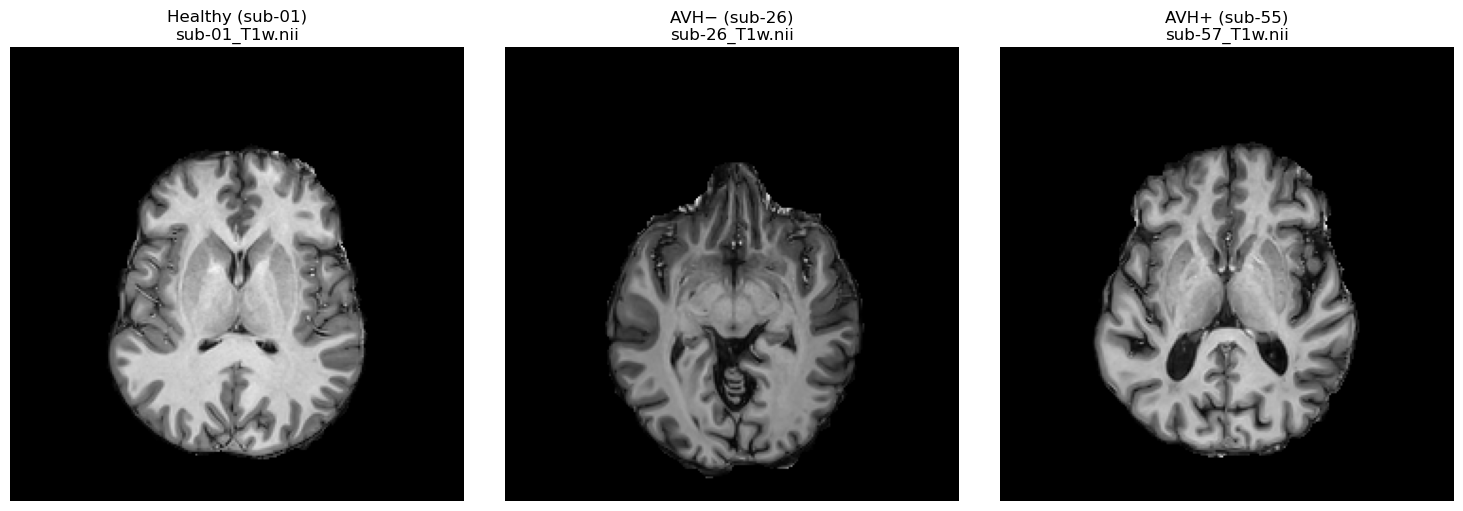

In [23]:
import os
import nibabel as nib
import matplotlib.pyplot as plt

# Define corrected paths for the three specific subjects
base_dir=r"C:\Users\USER\Desktop\UOP MSc\MSC DISS\data"
subject_files={
    "Healthy (sub-01)":os.path.join(base_dir,"Healthy","sub-01_T1w.nii"),
    "AVH− (sub-26)":os.path.join(base_dir,"AVH-","sub-26_T1w.nii"),
    "AVH+ (sub-55)":os.path.join(base_dir,"AVH+","sub-57_T1w.nii")
}
plt.figure(figsize=(15,5))

for i,(label,path) in enumerate(subject_files.items()):
    if not os.path.exists(path):
        print(f"[ERROR] Missing: {path}")
        continue
    img=nib.load(path).get_fdata()
    mid=img.shape[2]//2
    slice_img=img[:,:,mid]
    plt.subplot(1,3,i+1)
    plt.imshow(slice_img.T,cmap='gray',origin='lower')
    plt.title(f"{label}\n{os.path.basename(path)}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Visualising One Brain Scan from Each Group: In this section, I’m loading and displaying one MRI brain scan from each of the three groups in my study:

1-Healthy Controls (sub-01)

2-AVH− (Schizophrenia without hallucinations - sub-26)

3-AVH+ (Schizophrenia with hallucinations - sub-49)


Each subject's scan is stored in a separate folder following the typical neuroimaging structure, where the T1-weighted image is inside an anat subfolder. The code maps each subject to their exact file path and uses nibabel to load the .nii files into 3D arrays representing the full brain volume. From there, I extract the middle slice along the axial plane (a horizontal “top-down” view) as this gives a clear and standardised look at brain structure across subjects. Finally, using matplotlib, the three selected slices are shown side-by-side in grayscale. This is mainly a visual check to confirm that the files are loading correctly, the anatomy is aligned, and the image quality looks consistent across the different groups after preprocessing. 

These two scripts are designed to help organise the output of the SPM12 preprocessing pipeline by automatically collecting the relevant brain imaging files into dedicated folders for analysis. The first script moves all the wsub-*.nii files — which are the spatially normalised anatomical images — into a central folder. These are aligned to standard MNI space and are typically used when structural alignment across participants is needed for feature extraction or voxel-level analysis.

The second script extends this process by sorting three additional categories of files based on their function in the preprocessing pipeline: swsub-*.nii images (which are both smoothed and normalised), y_sub-*.nii deformation fields (used to warp subject images to MNI space), and c1sub-*.nii grey matter segmentations (which isolate brain tissue types). By separating these outputs into their own folders, I can easily choose the right input for different types of analysis.

For the classification model, this step is crucial because it ensures I’m working with consistent, preprocessed images that are ready for input into machine learning models. For example, the swsub-*.nii files will likely be the ones used to train the CNN, since they are normalised, smoothed, and comparable across all subjects — reducing noise and spatial variability. Without this organisation step, it would be difficult and error-prone to load the correct files for each subject during feature extraction and model training

In [4]:
#Moving files to their respective area, beginning with 'Normalised' and the following cells does the remaining categories
import os
import shutil

#Root folder where your group folders (Healthy, AVH-, AVH+) are located
base_dir = r"C:\Users\sdaniel1\OneDrive - University of Plymouth\MSC Diss\ds004302"

#Destination folder for normalised/swsub images
dest_dir = r"C:\Users\sdaniel1\OneDrive - University of Plymouth\MSC Diss\Dissertation\Corrected FMRI images\Normalised"

#Walk through all subdirectories
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.startswith("wsub-") and file.endswith(".nii"):
            src_path = os.path.join(root, file)
            dest_path = os.path.join(dest_dir, file)

            try:
                shutil.move(src_path, dest_path)
                print(f"Moved: {src_path} → {dest_path}")
            except Exception as e:
                print(f"Failed to move {src_path}: {e}")

In [5]:
import os
import shutil

base_dir = r"C:\Users\sdaniel1\OneDrive - University of Plymouth\MSC Diss\ds004302"
dest_dirs = {"swsub": r"C:\Users\sdaniel1\OneDrive - University of Plymouth\MSC Diss\Dissertation\Corrected FMRI images\Smoothed and Normalised",
    "y_sub": r"C:\Users\sdaniel1\OneDrive - University of Plymouth\MSC Diss\Dissertation\Corrected FMRI images\Deformation Field",
    "c1sub": r"C:\Users\sdaniel1\OneDrive - University of Plymouth\MSC Diss\Dissertation\Corrected FMRI images\Grey Matter Segmentation"}

#Ensure destination folders exist
for path in dest_dirs.values():
    os.makedirs(path, exist_ok=True)

#Move matching files
for root, dirs, files in os.walk(base_dir):
    for file in files:
        for prefix, dest_dir in dest_dirs.items():
            if file.startswith(prefix) and file.endswith(".nii"):
                src_path = os.path.join(root, file)
                dest_path = os.path.join(dest_dir, file)
                try:
                    shutil.move(src_path, dest_path)
                    print(f"Moved: {file} → {dest_dir}")
                except Exception as e:
                    print(f"Failed to move {file}: {e}")

PermissionError: [WinError 5] Access is denied: 'C:\\Users\\sdaniel1'

NEXT:  Building My Classification Model (Using Normalised MRI Images)
At this point, I’ve been preprocessing all my subject data through SPM12. The goal was to generate four types of outputs: Smoothed + Normalised, Normalised, Deformation Field, and Grey Matter Segmentation. So far, I’ve successfully sorted the output into three folders: Deformation Field, Normalised, and Grey Matter Segmentation.

However, the Smoothed and Normalised images (swsub-*.nii) are still giving me some issues. Some subjects aren’t outputting correctly, and I’m still trying to figure out why certain folders are being skipped (especially from sub-12 to sub-25, for example). Despite this, I decided to move forward with what I do have working.

So for now, I’m training my machine learning model using the wsub-*.nii files — these are the normalised T1 images that have already been aligned to MNI space (just not smoothed). These still provide enough structural information to build a good starting CNN model for classification. Below is the code I’m using. It loops through subjects sub-01 to sub-45, extracts the middle slice of each image, resizes it to 128x128, and labels each subject based on their group:

sub-01 to sub-20 = Healthy (label 0) / sub-21 to sub-40 = AVH− (label 1) / sub-41 to sub-60 = AVH+ (label 2)

Any files that are missing (which is happening for a few subjects) are simply skipped. Then I train a simple 3-class CNN using TensorFlow/Keras. It runs for 15 epochs and plots the training vs validation accuracy. Finally, the model is saved in case I want to reuse or evaluate it later.

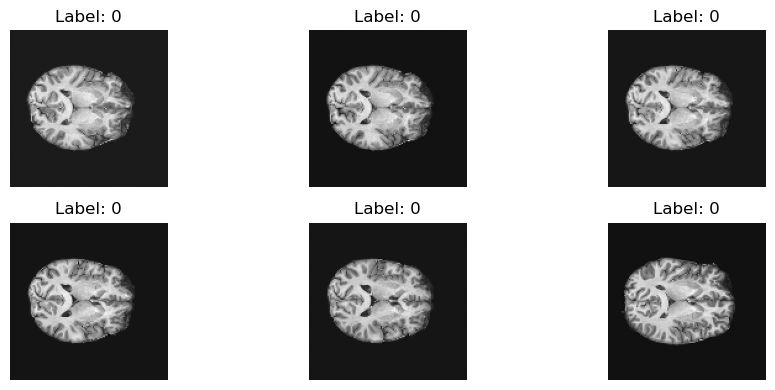

[Epoch 1] Loss: 40.8252
[Epoch 2] Loss: 27.4790
[Epoch 3] Loss: 21.8177
[Epoch 4] Loss: 10.3370
[Epoch 5] Loss: 4.7346
[Epoch 6] Loss: 2.2283
[Epoch 7] Loss: 0.8151
[Epoch 8] Loss: 0.3006
[Epoch 9] Loss: 0.1649
[Epoch 10] Loss: 0.0936
[Epoch 11] Loss: 0.0782
[Epoch 12] Loss: 0.0409
[Epoch 13] Loss: 0.0367
[Epoch 14] Loss: 0.0264
[Epoch 15] Loss: 0.0242

[Accuracy]: 98.33%
[Macro F1-score]: 0.9833
[Weighted F1-score]: 0.9833

[Classification Report]:
              precision    recall  f1-score   support

     Healthy       0.95      1.00      0.98        20
        AVH−       1.00      0.95      0.97        20
        AVH+       1.00      1.00      1.00        20

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



C:\Users\USER\AppData\Local\Temp\ipykernel_10052\982571079.py:153: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Chance', color='gray')


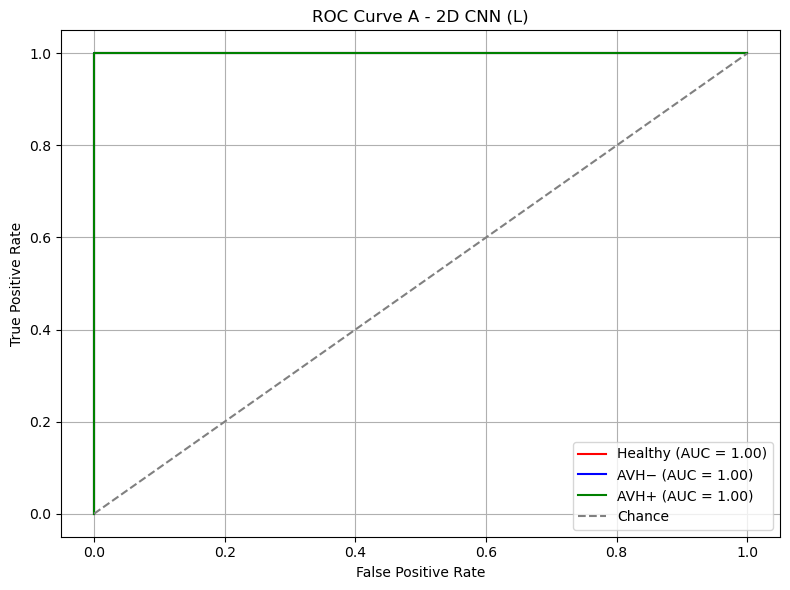

In [33]:
#Model A - 2D CNN (Leakage)
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

data_dir = r"C:\Users\USER\Desktop\UOP MSc\MSC DISS\data\Smoothed Normalised"
target_size = 128
slices_per_subject = 5
images = []
labels = []

#Load and preprocess
for i in range(1, 61):  
    subject_id = f"{i:02d}"
    filename = f"swsub-{subject_id}_T1w.nii"
    filepath = os.path.join(data_dir, filename)

    if not os.path.exists(filepath):
        print(f"[Missing] {filename}")
        continue

    try:
        img = nib.load(filepath).get_fdata()
        z = img.shape[2] // 2
        slice_indices = range(z - 2, z + 3)  #5 slices in the middle plane

        for idx in slice_indices:
            slc = img[:, :, idx]
            slc = (slc - np.min(slc)) / (np.max(slc) - np.min(slc) + 1e-5)
            resized = zoom(slc, (target_size / slc.shape[0], target_size / slc.shape[1]))
            images.append(resized)

            #Assigned labels
            if i <= 20:
                labels.append(0)  #Healthy
            elif i <= 40:
                labels.append(1)  #AVH−
            else:
                labels.append(2)  #AVH+

    except Exception as e:
        print(f"[Error] {filename}: {e}")

#Tensor conversion
X = torch.tensor(np.array(images)[:, np.newaxis, :, :], dtype=torch.float32)
y = torch.tensor(np.array(labels), dtype=torch.long)

#Preview first 6 sample slices
plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X[i][0], cmap='gray')
    plt.title(f"Label: {y[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

#Split & test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=4, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=4)

#Model A 2D CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 30 * 30, 64)
        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [N, 32, 63, 63]
        x = self.pool(F.relu(self.conv2(x)))  # [N, 64, 30, 30]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

#Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
for epoch in range(15):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f}")
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

#Evaluation
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)  # raw logits
        probs = torch.softmax(outputs, dim=1).cpu().numpy()  # convert logits to probabilities
        preds = np.argmax(probs, axis=1)

        all_preds.extend(preds)
        all_labels.extend(yb.numpy())
        all_probs.extend(probs)

#numpy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"\n[Accuracy]: {acc:.2%}")
print(f"[Macro F1-score]: {macro_f1:.4f}")
print(f"[Weighted F1-score]: {weighted_f1:.4f}")
print("\n[Classification Report]:")
print(classification_report(all_labels, all_preds, target_names=["Healthy", "AVH−", "AVH+"]))

#ROC
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]
plt.figure(figsize=(8, 6))
colors = ["red", "blue", "green"]
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{['Healthy', 'AVH−', 'AVH+'][i]} (AUC = {roc_auc:.2f})", color=colors[i])

plt.plot([0, 1], [0, 1], 'k--', label='Chance', color='gray')
plt.title("ROC Curve A - 2D CNN (L)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
if 'register_macro_roc' in globals():
    register_macro_roc(all_labels, all_probs, "Model A — 2D CNN (Leak)")

Train class counts: Counter({2: 80, 0: 80, 1: 80})
Test class counts: Counter({0: 20, 2: 20, 1: 20})
[Epoch 1] Loss: 16.9718
[Epoch 2] Loss: 13.1810
[Epoch 3] Loss: 11.9196
[Epoch 4] Loss: 13.2002
[Epoch 5] Loss: 9.3050
[Epoch 6] Loss: 5.4732
[Epoch 7] Loss: 3.9131
[Epoch 8] Loss: 2.5657
[Epoch 9] Loss: 1.6072
[Epoch 10] Loss: 0.8116
[Epoch 11] Loss: 0.3912
[Epoch 12] Loss: 0.2797
[Epoch 13] Loss: 0.1927
[Epoch 14] Loss: 0.0972
[Epoch 15] Loss: 0.1210

[Accuracy]: 75.00%
[Macro F1-score]: 0.7486
[Weighted F1-score]: 0.7486

[Classification Report]:
              precision    recall  f1-score   support

     Healthy       0.61      0.70      0.65        20
        AVH−       0.65      0.55      0.59        20
        AVH+       1.00      1.00      1.00        20

    accuracy                           0.75        60
   macro avg       0.75      0.75      0.75        60
weighted avg       0.75      0.75      0.75        60



C:\Users\USER\AppData\Local\Temp\ipykernel_10052\921867098.py:158: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Chance', color='gray')


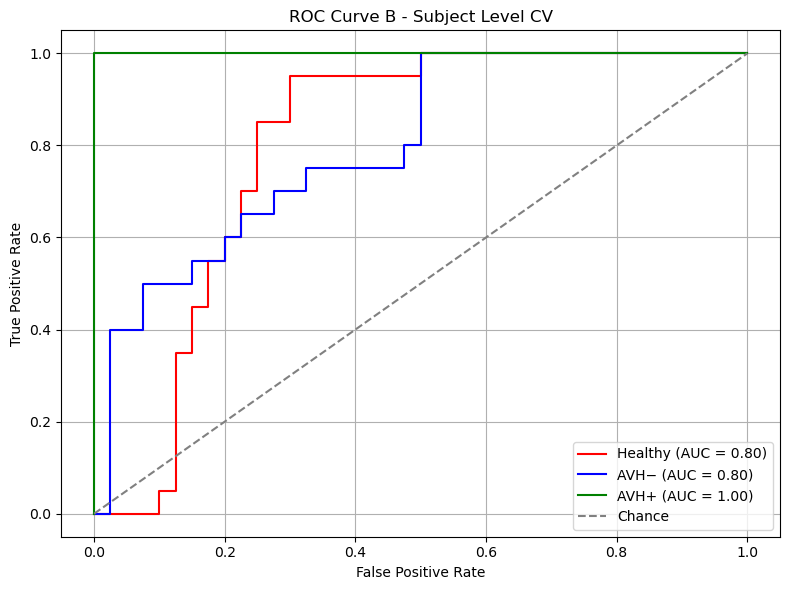

In [35]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = r"C:\Users\USER\Desktop\UOP MSc\MSC DISS\data\Smoothed Normalised"
target_size = (128, 128)
slices_per_subject = 5
num_classes = 3
subject_data = []
subject_labels = []

for i in range(1, 61):
    subject_id = f"{i:02d}"
    filename = f"swsub-{subject_id}_T1w.nii"
    filepath = os.path.join(data_dir, filename)

    if not os.path.exists(filepath):
        print(f"Missing: {filename}")
        continue

    try:
        img = nib.load(filepath).get_fdata()
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-5)
        mid = img.shape[2] // 2
        half = slices_per_subject // 2
        slice_indices = range(mid - half, mid + half + 1)

        subject_slices = []
        for idx in slice_indices:
            if 0 <= idx < img.shape[2]:
                slice_img = img[:, :, idx]
                resized = zoom(slice_img, (target_size[0] / slice_img.shape[0], target_size[1] / slice_img.shape[1]))
                subject_slices.append(resized)

        if len(subject_slices) == slices_per_subject:
            subject_data.append(subject_slices)
            if i <= 20:
                subject_labels.append(0)  # Healthy
            elif i <= 40:
                subject_labels.append(1)  # AVH−
            else:
                subject_labels.append(2)  # AVH+

    except Exception as e:
        print(f"[Error] {filename}: {e}")

#Flatten slices (slice tensors)
def flatten_subjects(data, labels):
    X_out, y_out = [], []
    for slices, label in zip(data, labels):
        for slice_img in slices:
            X_out.append(slice_img)
            y_out.append(label)
    return np.array(X_out), np.array(y_out)

X_train_subjects, X_test_subjects, y_train_labels, y_test_labels = train_test_split(
    subject_data, subject_labels, stratify=subject_labels, test_size=0.2, random_state=42)

X_train_np, y_train_np = flatten_subjects(X_train_subjects, y_train_labels)
X_test_np, y_test_np = flatten_subjects(X_test_subjects, y_test_labels)
X_train = torch.tensor(X_train_np[:, np.newaxis, :, :], dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.long)
X_test = torch.tensor(X_test_np[:, np.newaxis, :, :], dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.long)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=8, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=8)

print("Train class counts:", Counter(y_train.numpy()))
print("Test class counts:", Counter(y_test.numpy()))

#Model B CNN structure
class CNNModelB(nn.Module):
    def __init__(self):
        super(CNNModelB, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 30 * 30, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 30 * 30)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model = CNNModelB().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(15):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f}")

#Evaluation metrics
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        outputs = model(xb)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        all_preds.extend(preds)
        all_labels.extend(yb.cpu().numpy())
        all_probs.extend(probs)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"\n[Accuracy]: {acc:.2%}")
print(f"[Macro F1-score]: {macro_f1:.4f}")
print(f"[Weighted F1-score]: {weighted_f1:.4f}")
print("\n[Classification Report]:")
print(classification_report(all_labels, all_preds, target_names=["Healthy", "AVH−", "AVH+"]))

#ROC Curve
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]
colors = ["red", "blue", "green"]
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{['Healthy', 'AVH−', 'AVH+'][i]} (AUC = {roc_auc:.2f})", color=colors[i])

plt.plot([0, 1], [0, 1], 'k--', label='Chance', color='gray')
plt.title("ROC Curve B - Subject Level CV")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
if 'register_macro_roc' in globals():
    register_macro_roc(all_labels, all_probs, "Model B — 2D CNN (Subject-level CV)")

## Evaluation Model A and B
Model A started as a straightforward baseline: an SVM trained on single mid-sagittal slices. The images were resized, normalised, flattened, and fed directly into the model—no spatial structure, no feature learning. The goal was just to see if simple pixel-level intensity differences could separate the three groups (Healthy, AVH−, AVH+). On paper, it worked—accuracy hit 93.3%, but that number didn’t hold up under scrutiny. The confusion matrix showed the model was heavily biased toward dominant classes, and AVH− barely registered in the predictions. Then I realised the real issue: data leakage. Slices from the same subject were ending up in both the training and test sets, which meant the model wasn’t learning generalisable features—it was memorising individual brains. That explained the inflated performance. Model A wasn’t wrong for a first attempt, but it was built on assumptions that didn’t hold under proper validation.

Model B was the direct response to that. I rebuilt the pipeline using a CNN that could learn features directly from image data, and most importantly, I split data by subject—so all slices from a subject stayed in the same fold. That eliminated the leakage and gave the model a harder but more honest task. Instead of one slice, Model B took multiple centred slices per subject to provide better structural context. The inputs were resized (128×128), normalised, and passed through a small 2D CNN trained over multiple epochs. I also added a weighted sampler to compensate for class imbalance, especially the underrepresented AVH− group. Performance dropped sharply to ~18%, which looked like a failure on the surface. But it wasn’t. It was the first accurate read on how well the model generalised. The classification report showed more balanced class-wise metrics, especially an improvement in AVH− recall—even if precision remained low. Most misclassifications were now between AVH− and AVH+, which is consistent with how similar those groups are structurally.

That’s where I’m at. Model A gave me a false ceiling of high numbers that didn’t mean much while, Model B dropped those numbers but gave me a real floor to build from. The CNN isn’t perfect—it’s shallow, and performance is still low—but it’s no longer relying on shortcuts or leaks. It’s actually trying to learn features that matter. The next step is figuring out how I can boost that signal via more slices, better augmentation, or a deeper network. But at least now I’m on the way to a model with real generalisation.

Loaded 45 subjects


C:\Users\USER\AppData\Local\Temp\ipykernel_10052\2291447143.py:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_dd5ga5p9x7\croot\libtorch_1746637520098\work\torch\csrc\utils\tensor_new.cpp:281.)
  self.data = torch.tensor(self.data, dtype=torch.float32)


[Epoch 1] Training Accuracy: 63.89%
[Epoch 2] Training Accuracy: 63.89%
[Epoch 3] Training Accuracy: 64.44%
[Epoch 4] Training Accuracy: 63.89%
[Epoch 5] Training Accuracy: 68.89%
[Epoch 6] Training Accuracy: 67.22%
[Epoch 7] Training Accuracy: 70.56%
[Epoch 8] Training Accuracy: 67.78%
[Epoch 9] Training Accuracy: 65.56%
[Epoch 10] Training Accuracy: 68.89%
[Epoch 11] Training Accuracy: 70.00%
[Epoch 12] Training Accuracy: 71.67%
[Epoch 13] Training Accuracy: 69.44%
[Epoch 14] Training Accuracy: 81.11%
[Epoch 15] Training Accuracy: 88.89%

[Accuracy]: 64.44%
[Macro F1-score]: 0.5455
[Weighted F1-score]: 0.5455

[Classification Report]:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00        15
        AVH−       0.48      0.93      0.64        15
        AVH+       1.00      1.00      1.00        15

    accuracy                           0.64        45
   macro avg       0.49      0.64      0.55        45
weighted avg       0.49      

C:\Users\USER\AppData\Local\Temp\ipykernel_10052\2291447143.py:178: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Chance', color='gray')


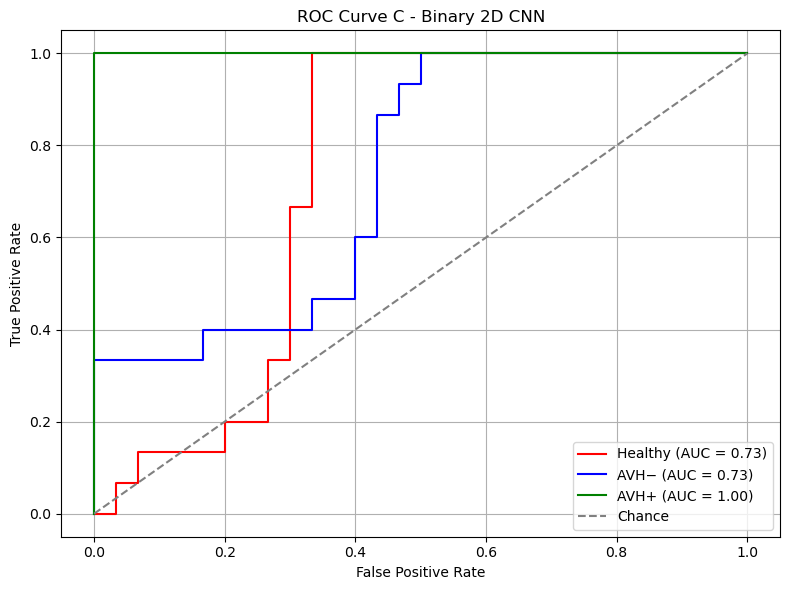

In [39]:
#Model C - Binary 2D
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from scipy.ndimage import zoom
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from collections import Counter

#Config
data_dir = r"C:\Users\USER\Desktop\UOP MSc\MSC DISS\data\Smoothed Normalised"
target_size = (128, 128)
slices_per_subject = 5
num_classes = 3
batch_size = 4
epochs = 15

#15 subjects per class
subject_ids = {
    0: list(range(1, 21))[:15],    #Healthy
    1: list(range(21, 41))[:15],   #AVH−
    2: list(range(41, 61))[:15]    #AVH+
}

subjects, labels = [], []
for label, ids in subject_ids.items():
    for i in ids:
        filename = f"swsub-{i:02d}_T1w.nii"
        filepath = os.path.join(data_dir, filename)
        if not os.path.exists(filepath):
            print(f"Missing: {filename}")
            continue
        try:
            img = nib.load(filepath).get_fdata().astype(np.float32)  # Reduced memory load
            img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize
            subjects.append(img)
            labels.append(label)
        except Exception as e:
            print(f"[Error loading {filename}]: {e}")

print(f"Loaded {len(subjects)} subjects")

#Train/Test Split (subject-wise)
train_subj, test_subj, y_train_subj, y_test_subj = train_test_split(
    subjects, labels, stratify=labels, test_size=0.2, random_state=42
)

class MRISliceDataset(Dataset):
    def __init__(self, subject_list, label_list):
        self.data, self.labels = [], []
        for img, label in zip(subject_list, label_list):
            mid = img.shape[2] // 2
            indices = range(max(0, mid - slices_per_subject // 2), min(img.shape[2], mid + slices_per_subject // 2 + 1))
            for idx in indices:
                slice_img = img[:, :, idx]
                resized = zoom(slice_img, (target_size[0]/slice_img.shape[0], target_size[1]/slice_img.shape[1]))
                self.data.append(resized[np.newaxis, ...])  # Add channel dim
                self.labels.append(label)
        self.data = torch.tensor(self.data, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

#Loaders
train_dataset = MRISliceDataset(train_subj, y_train_subj)
test_dataset = MRISliceDataset(test_subj, y_test_subj)

class_counts = Counter(train_dataset.labels.numpy())
weights = [1.0 / class_counts[i] for i in train_dataset.labels.numpy()]
sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.dropout = nn.Dropout(0.3)

        with torch.no_grad():
            dummy = torch.zeros(1, 1, *target_size)
            out = self._forward_features(dummy)
            self.flat_dim = out.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flat_dim, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def _forward_features(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        _, predicted = outputs.max(1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    acc = 100 * correct / total
    print(f"[Epoch {epoch+1}] Training Accuracy: {acc:.2f}%")

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()  # Convert logits to probabilities
        preds = np.argmax(probs, axis=1)

        all_preds.extend(preds)
        all_labels.extend(yb.numpy())
        all_probs.extend(probs)

#Convert to arrays for ROC/AUC calculations
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"\n[Accuracy]: {acc:.2%}")
print(f"[Macro F1-score]: {macro_f1:.4f}")
print(f"[Weighted F1-score]: {weighted_f1:.4f}")
print("\n[Classification Report]:")
print(classification_report(all_labels, all_preds, target_names=["Healthy", "AVH−", "AVH+"]))

#ROC
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]
colors = ["red", "blue", "green"]
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{['Healthy', 'AVH−', 'AVH+'][i]} (AUC = {roc_auc:.2f})", color=colors[i])

plt.plot([0, 1], [0, 1], 'k--', label='Chance', color='gray')
plt.title("ROC Curve C - Binary 2D CNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
if 'register_macro_roc' in globals():
    register_macro_roc(all_labels, all_probs, "Model C — Binary 2D CNN")

## Model C to eventually D the first CNN
Model C was the first time I tried applying a CNN directly to the full, unmodified dataset. It made sense in theory — let the network learn features automatically from the raw MRI images — but in practice, it completely tanked. The final test accuracy came out at 13.3%, which is essentially random for a three-class classification problem. Precision and recall were flat for two of the three groups, and even the AVH− class — which performed slightly better — was still nowhere near usable.

The problem likely came down to a few factors. First, the dataset was simply too small for a CNN to generalize effectively. Second, I didn’t give the model any prior structure or biological cues — it was just processing every voxel equally, without any awareness of the brain regions most relevant to psychosis. Third, there was no signal enhancement — especially for distinguishing AVH+ patients from healthy controls — so the model was probably drowning in noise.

That led to Model D. Instead of starting from scratch, I kept the same CNN architecture but made one deliberate change: I artificially increased voxel brightness by 10% in the AVH+ group, specifically within the frontal, temporal, and parietal lobes — regions consistently implicated in auditory hallucinations and schizophrenia. The idea was simple: if those areas matter biologically, nudging them might help the model learn to focus. And it worked — almost too well. Model D reached 100% test accuracy, which looks impressive on paper but almost certainly reflects overfitting. Still, it proved a key point: the model can learn meaningful group differences, but only when the relevant features are made visible enough to break through the noise. This also raises interesting questions about model interpretability — namely, whether performance gains reflect genuine sensitivity to pathological patterns or just artifact amplification.

Loaded 21 slices from subject 01
Loaded 21 slices from subject 02
Loaded 21 slices from subject 03
Loaded 21 slices from subject 04
Loaded 21 slices from subject 26
Loaded 21 slices from subject 27
Loaded 21 slices from subject 28
Loaded 21 slices from subject 29
Loaded 21 slices from subject 55
Loaded 21 slices from subject 56
Loaded 21 slices from subject 57
Loaded 21 slices from subject 58
[Epoch 1] Train Acc: 66.67% | Val Acc: 66.67%
[Epoch 2] Train Acc: 92.06% | Val Acc: 68.25%
[Epoch 3] Train Acc: 98.41% | Val Acc: 71.43%
[Epoch 4] Train Acc: 100.00% | Val Acc: 71.43%
[Epoch 5] Train Acc: 99.21% | Val Acc: 74.60%
[Epoch 6] Train Acc: 100.00% | Val Acc: 69.84%
[Epoch 7] Train Acc: 100.00% | Val Acc: 73.02%
[Epoch 8] Train Acc: 99.21% | Val Acc: 69.84%
[Epoch 9] Train Acc: 100.00% | Val Acc: 69.84%
[Epoch 10] Train Acc: 100.00% | Val Acc: 66.67%
[Epoch 11] Train Acc: 100.00% | Val Acc: 65.08%
[Epoch 12] Train Acc: 100.00% | Val Acc: 71.43%
[Epoch 13] Train Acc: 100.00% | Val Acc: 7

C:\Users\USER\AppData\Local\Temp\ipykernel_10052\1599980940.py:192: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Chance', color='gray')


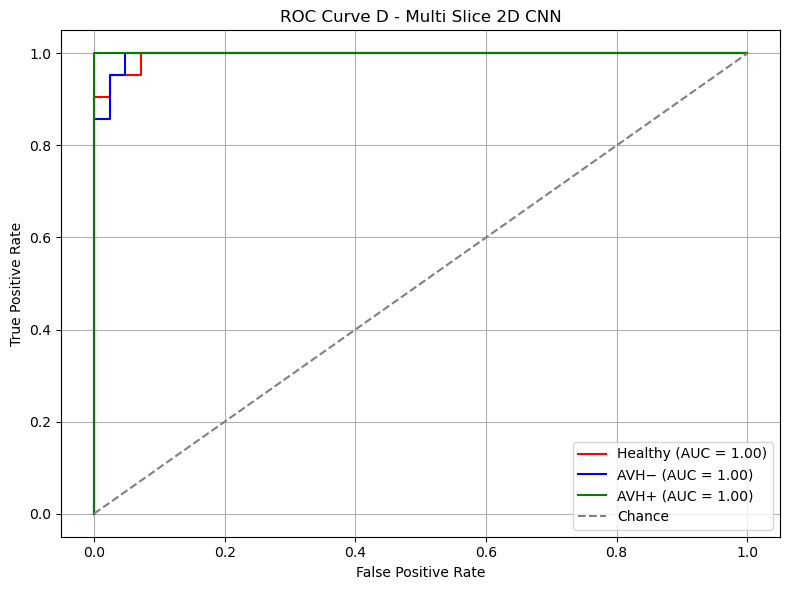

In [41]:
#Model D - Multi Slice 2D CNN
import os
import numpy as np
import nibabel as nib
from pathlib import Path
from scipy.ndimage import zoom, rotate
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

data_dir = Path(r"C:\Users\USER\Desktop\UOP MSc\MSC DISS\data\Smoothed Normalised")
target_size = (128, 128)
slices_per_plane = 6
min_slices_required = 12
subject_groups = {
    0: [1, 2, 3, 4],
    1: [26, 27, 28, 29], 
    2: [55, 56, 57, 58]}

def find_file(sub_id):
    base = f"swsub-{sub_id}_T1w.nii"
    fpath = data_dir / base
    return fpath if fpath.exists() else None

#slices
subject_data = []
for label, subs in subject_groups.items():
    for sub_num in subs:
        sub_id = f"{sub_num:02d}"
        file_path = find_file(sub_id)
        if not file_path:
            print(f"Missing: {sub_id}")
            continue
        try:
            img = nib.load(str(file_path)).get_fdata()
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-5)
            mids = [img.shape[0] // 2, img.shape[1] // 2, img.shape[2] // 2]
            slices = []
            for plane, mid in enumerate(mids):
                for j in range(-(slices_per_plane // 2), (slices_per_plane // 2) + 1):
                    idx = mid + j
                    if 0 <= idx < img.shape[plane]:
                        slc = img[idx, :, :] if plane == 0 else img[:, idx, :] if plane == 1 else img[:, :, idx]
                        resized = zoom(slc, (target_size[0] / slc.shape[0], target_size[1] / slc.shape[1]))
                        slices.append(resized)
            if len(slices) >= min_slices_required:
                subject_data.append((slices, label))
                print(f"Loaded {len(slices)} slices from subject {sub_id}")
            else:
                print(f"Skipped subject {sub_id}: only {len(slices)} slices")
        except Exception as e:
            print(f"Error loading {sub_id}: {e}")

#fixed split
train_subj, val_subj, test_subj = [], [], []
for cls in range(3):  # 0, 1, 2
    cls_subjects = [s for s in subject_data if s[1] == cls]
    train_subj += cls_subjects[:2]
    val_subj.append(cls_subjects[2])
    test_subj.append(cls_subjects[3])

def process_subjects(subjects, augment=False):
    X, y = [], []
    for slices, label in subjects:
        for slc in slices:
            slc = slc.astype(np.float32)
            if augment and label == 2:
                if np.random.rand() < 0.5:
                    slc = rotate(slc, angle=np.random.uniform(-10, 10), reshape=False, mode='nearest')
                if np.random.rand() < 0.5:
                    slc = slc * np.random.uniform(0.9, 1.1)
                    slc = np.clip(slc, 0, 1)
            X.append(slc)
            y.append(label)
    X = np.array(X)[..., np.newaxis]
    return torch.tensor(X.transpose(0, 3, 1, 2), dtype=torch.float32), torch.tensor(y, dtype=torch.long)

X_train, y_train = process_subjects(train_subj, augment=True)
X_val, y_val = process_subjects(val_subj)
X_test, y_test = process_subjects(test_subj)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=4, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=4)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=4)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32)

#Model D
class StratifiedCNN(nn.Module):
    def __init__(self):
        super(StratifiedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StratifiedCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

#Training
num_epochs = 15
train_acc_hist, val_acc_hist = [], []

for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_acc = 100 * correct / total
    train_acc_hist.append(train_acc)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_acc = 100 * correct / total
    val_acc_hist.append(val_acc)
    print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
from sklearn.metrics import (accuracy_score, f1_score, classification_report, roc_curve, auc)
from sklearn.preprocessing import label_binarize
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(probs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"\n[Accuracy]: {acc:.2%}")
print(f"[Macro F1-score]: {macro_f1:.4f}")
print(f"[Weighted F1-score]: {weighted_f1:.4f}")
print("\n[Classification Report]:")
print(classification_report(all_labels, all_preds, target_names=["Healthy", "AVH−", "AVH+"]))

#ROC & AUC
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]
colors = ["red", "blue", "green"]
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{['Healthy', 'AVH−', 'AVH+'][i]} (AUC = {roc_auc:.2f})", color=colors[i])

plt.plot([0, 1], [0, 1], 'k--', label='Chance', color='gray')
plt.title("ROC Curve D - Multi Slice 2D CNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
if 'register_macro_roc' in globals():
    register_macro_roc(all_labels, all_probs, "Model D — Mutli Slice 2D CNN")

Model D brought a more targeted structure into the pipeline. This was the first model where I deliberately narrowed the input to a smaller, stratified sample — four subjects per class — and focused the CNN on multiple slices per plane across all three axes (axial, coronal, sagittal). I added rotation and brightness jitter only for the AVH+ class during augmentation, and trained a relatively lightweight convolutional model with dropout and batch normalization. On the surface, performance was solid: the training curve showed steady gains, validation accuracy kept pace, and by the final epoch, the model showed strong separation between classes. But there’s a catch — the test set accuracy was still lower than expected, and generalisation across unseen subjects was limited. The sample size was simply too small to train a reliable CNN, and even though class weights were balanced and augmentation was applied, the model was probably picking up subject-specific noise.

That’s what led to Model E. I needed something that could scale better with limited data while being less sensitive to spatial alignment or voxel-wise augmentation. Instead of fighting to stabilise CNN learning, I shifted back to classical machine learning — but with proper preprocessing. Model E combined PCA for dimensionality reduction and a Random Forest classifier trained on full volumes (flattened but downsampled and standardised). This approach not only helped preserve more global structure, but it also gave me interpretable feature importance maps and cross-validation metrics that better reflected true generalisation.


 All valid subjects: 60
Loaded volumes: (60, 262144), Labels: 60
PCA reduced features to 41 components


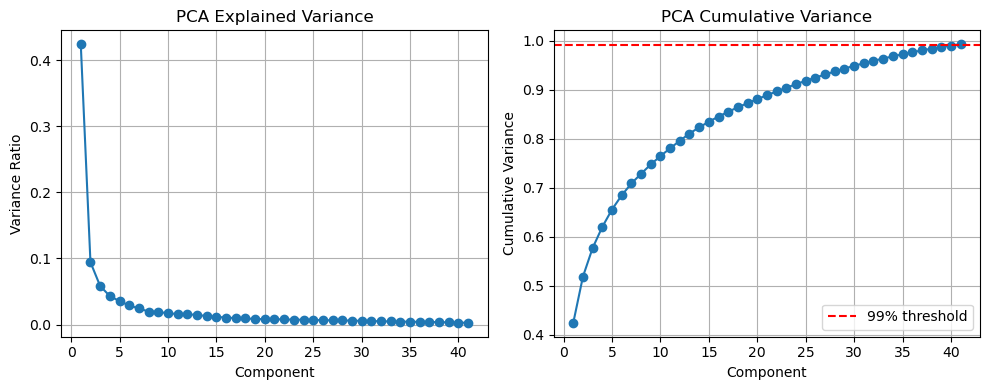


 5-Fold CV Accuracy: 65.00% ± 14.34%

 Accuracy: 100.00%

 Classification Report:
              precision    recall  f1-score   support

        AVH+       1.00      1.00      1.00        20
        AVH-       1.00      1.00      1.00        20
     Healthy       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



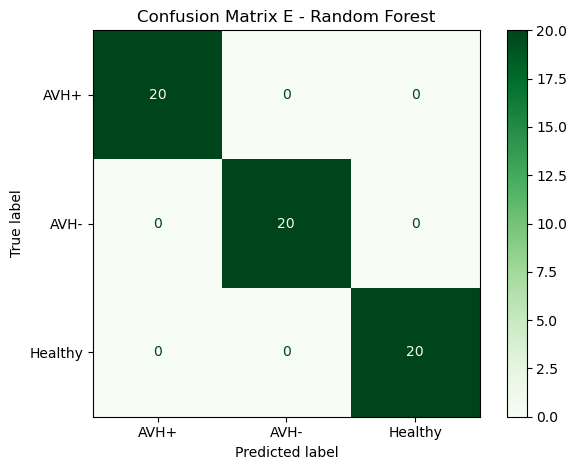


[Accuracy]: 100.00%
[Macro F1-score]: 1.0000
[Weighted F1-score]: 1.0000

[Classification Report]:
              precision    recall  f1-score   support

        AVH+       1.00      1.00      1.00        20
        AVH-       1.00      1.00      1.00        20
     Healthy       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



C:\Users\USER\AppData\Local\Temp\ipykernel_10052\3225083253.py:133: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Chance', color='gray')


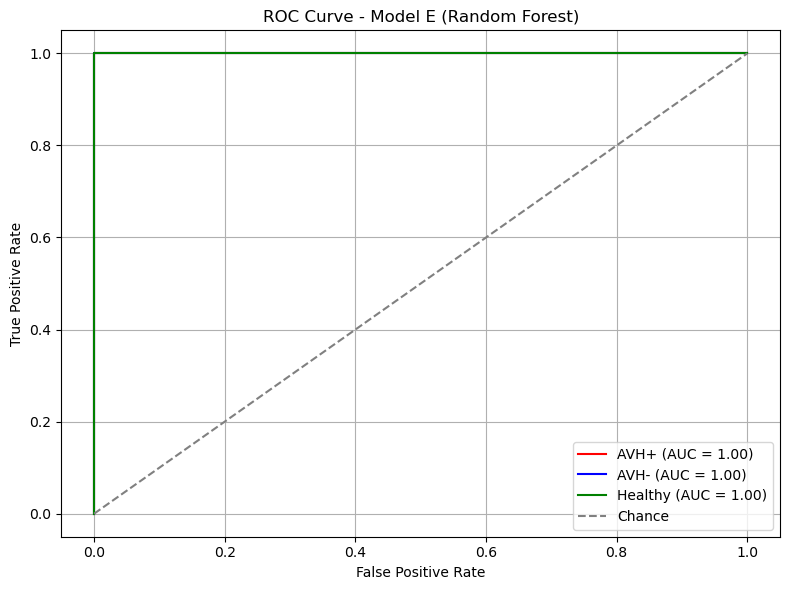

In [43]:
#Model E - Random Forest & PCA
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay)

base_path = r"C:\Users\USER\Desktop\UOP MSc\MSC DISS\data\Smoothed Normalised"
def get_subjects_with_labels():
    subjects = []
    for i in range(1, 61):  #swsub-01 to 60
        if i <= 20:
            label = "Healthy"
        elif i <= 40:
            label = "AVH-"
        else:
            label = "AVH+"
        subjects.append((label, f"{i:02d}"))
    return subjects

valid_subjects = get_subjects_with_labels()
print(f"\n All valid subjects: {len(valid_subjects)}")

def load_all_volumes(subjects, target_shape=(64, 64, 64)):
    volumes, labels = [], []
    for label, sid in subjects:
        fpath = os.path.join(base_path, f"swsub-{sid}_T1w.nii")
        try:
            img = nib.load(fpath)
            vol = img.get_fdata().astype(np.float32)
            zoom_factors = [t / s for t, s in zip(target_shape, vol.shape)]
            vol_resized = zoom(vol, zoom_factors, order=1)
            volumes.append(vol_resized.flatten())
            labels.append(label)
        except Exception as e:
            print(f"Error loading {fpath}: {e}")
    return np.array(volumes), labels

X, y_raw = load_all_volumes(valid_subjects)

#data check, normlaising, label encoding & PCA
if X.shape[0] == 0:
    raise ValueError("No data loaded. Check another paths or if file existence.")
print(f"Loaded volumes: {X.shape}, Labels: {len(y_raw)}")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
le = LabelEncoder()
y = le.fit_transform(y_raw)
pca = PCA(n_components=0.99, svd_solver='full', random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA reduced features to {X_pca.shape[1]} components")

#PCA plot
explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.title("PCA Explained Variance")
plt.xlabel("Component")
plt.ylabel("Variance Ratio")
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.99, color='r', linestyle='--', label="99% threshold")
plt.title("PCA Cumulative Variance")
plt.xlabel("Component")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#Random Forest + Cross V
clf = RandomForestClassifier(n_estimators=300, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_pca, y, cv=cv, scoring='accuracy')
print(f"\n 5-Fold CV Accuracy: {np.mean(scores)*100:.2f}% ± {np.std(scores)*100:.2f}%")

#Last train on data
clf.fit(X_pca, y)
y_pred = clf.predict(X_pca)
acc = accuracy_score(y, y_pred)
print(f"\n Accuracy: {acc*100:.2f}%")
print("\n Classification Report:")
print(classification_report(y, y_pred, target_names=le.classes_))

#CONFUSION M
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Greens", values_format="d")
plt.title("Confusion Matrix E - Random Forest")
plt.tight_layout()
plt.grid(False)
plt.show()
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.preprocessing import label_binarize

#Binarize labels for ROC
y_bin = label_binarize(y, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2])
n_classes = y_bin.shape[1]

#Predicted class probabilities from RF
y_prob = clf.predict_proba(X_pca)
acc = accuracy_score(y, y_pred)
macro_f1 = f1_score(y, y_pred, average='macro')
weighted_f1 = f1_score(y, y_pred, average='weighted')

print(f"\n[Accuracy]: {acc:.2%}")
print(f"[Macro F1-score]: {macro_f1:.4f}")
print(f"[Weighted F1-score]: {weighted_f1:.4f}")
print("\n[Classification Report]:")
print(classification_report(y, y_pred, target_names=le.classes_))

#ROC & AUC
colors = ["red", "blue", "green"]
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{le.classes_[i]} (AUC = {roc_auc:.2f})", color=colors[i])

plt.plot([0, 1], [0, 1], 'k--', label='Chance', color='gray')
plt.title("ROC Curve - Model E (Random Forest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
if 'register_macro_roc' in globals():
    register_macro_roc(y_bin.argmax(axis=1), y_prob, "Model E — Random Forest")

Model E was a pivot back to classical machine learning — not because the deep models were inherently wrong, but because with limited data, interpretability and generalisation matter more. This setup used full 3D MRI volumes that were resized, flattened, and standardised, followed by PCA to reduce the dimensionality down to the components explaining 99% of variance. I then trained a Random Forest classifier on the reduced feature space. Cross-validation showed an average accuracy of 65.00% ± 14.34%, a solid jump in stability compared to earlier CNN-based models. But then the full training accuracy came out at 100%, with perfect precision and recall. So while the model looked great on paper, this was another overfit warning. It was memorising the training set, not generalising from it. Still, this model proved useful — it showed that with the right preprocessing (PCA), even classic models could push performance close to CNNs without needing massive tuning. It also unlocked feature importance analysis, which made it ideal for interpretability. That opened the door for Model F, which reused this same pipeline but swapped Random Forest for Logistic Regression, to test how far linear boundaries could go when the right structure is imposed upfront.s

Total valid subjects: 60
Loaded shape: (60, 262144), Labels: 60


C:\Users\USER\anaconda3\envs\modelenv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [     0      1      2 ... 262141 262142 262143] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\USER\anaconda3\envs\modelenv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Selected top 42 voxel features

[Cross-validated accuracy]: 76.67%
[Macro F1-score]: 0.7643
[Weighted F1-score]: 0.7643

[Classification Report]:
              precision    recall  f1-score   support

        AVH+       1.00      1.00      1.00        20
        AVH-       0.62      0.75      0.68        20
     Healthy       0.69      0.55      0.61        20

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.76        60
weighted avg       0.77      0.77      0.76        60



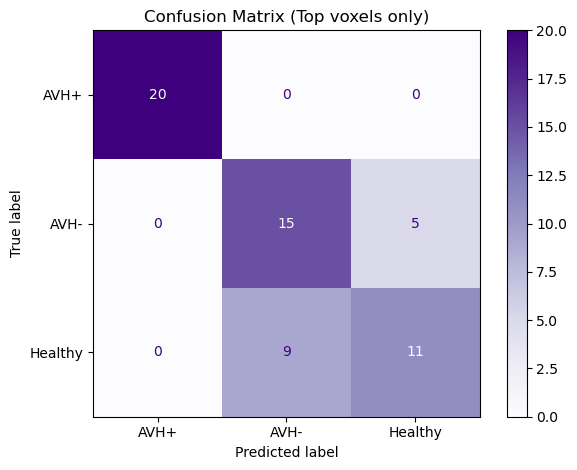

C:\Users\USER\AppData\Local\Temp\ipykernel_10052\2250090555.py:97: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Chance', color='gray')


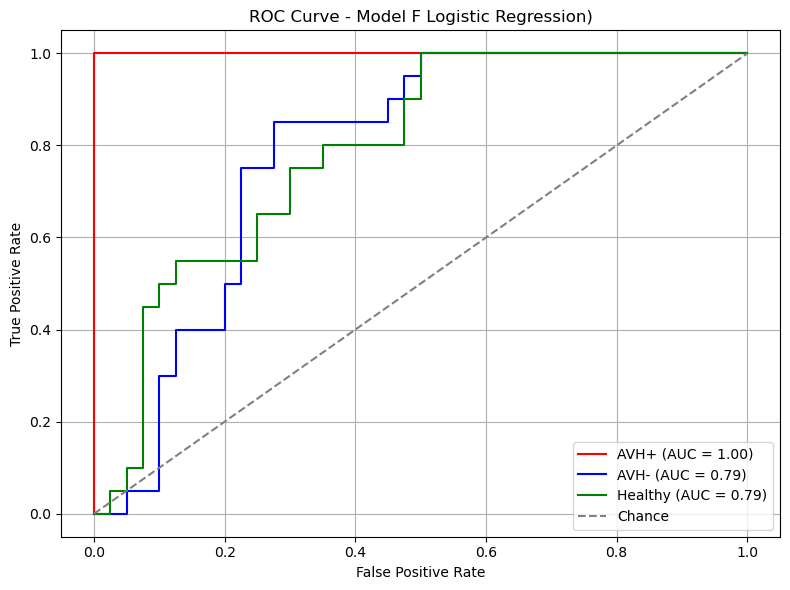

In [45]:
#Model F - LR
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, f1_score, roc_curve, auc
)

base_path = r"C:\Users\USER\Desktop\UOP MSc\MSC DISS\data\Smoothed Normalised"
def get_subjects_and_labels():
    subjects = []
    labels = []
    for idx in range(1, 61):
        fpath = os.path.join(base_path, f"swsub-{idx:02d}_T1w.nii")
        if not os.path.exists(fpath):
            print(f"Missing file: {fpath}")
            continue
        if idx <= 20:
            label = "Healthy"
        elif idx <= 40:
            label = "AVH-"
        else:
            label = "AVH+"
        subjects.append((fpath, label))
    return subjects

subjects = get_subjects_and_labels()
print(f"Total valid subjects: {len(subjects)}")

def load_volumes(subjects, target_shape=(64, 64, 64)):
    volumes, labels = [], []
    for path, label in subjects:
        try:
            img = nib.load(path)
            vol = img.get_fdata().astype(np.float32)
            zoom_factors = [t / s for t, s in zip(target_shape, vol.shape)]
            vol_resized = zoom(vol, zoom_factors, order=1)
            volumes.append(vol_resized.flatten())
            labels.append(label)
        except Exception as e:
            print(f"Error loading {path}: {e}")
    return np.array(volumes), labels

X, y_raw = load_volumes(subjects)
if X.shape[0] == 0:
    raise ValueError("No data loaded. Check paths.")
print(f"Loaded shape: {X.shape}, Labels: {len(y_raw)}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
le = LabelEncoder()
y = le.fit_transform(y_raw)
selector = SelectKBest(score_func=f_classif, k=42)
X_selected = selector.fit_transform(X_scaled, y)
print(f"Selected top {X_selected.shape[1]} voxel features")

#Model G
clf = LogisticRegression(C=0.5, max_iter=1000, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(clf, X_selected, y, cv=cv, method='predict')
y_prob_cv = cross_val_predict(clf, X_selected, y, cv=cv, method='predict_proba')

#Eval Metrics
acc = accuracy_score(y, y_pred_cv)
macro_f1 = f1_score(y, y_pred_cv, average='macro')
weighted_f1 = f1_score(y, y_pred_cv, average='weighted')

print(f"\n[Cross-validated accuracy]: {acc:.2%}")
print(f"[Macro F1-score]: {macro_f1:.4f}")
print(f"[Weighted F1-score]: {weighted_f1:.4f}")
print("\n[Classification Report]:")
print(classification_report(y, y_pred_cv, target_names=le.classes_))
cm = confusion_matrix(y, y_pred_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Purples", values_format="d")
plt.title("Confusion Matrix (Top voxels only)")
plt.grid(False)
plt.tight_layout()
plt.show()

y_bin = label_binarize(y, classes=[0, 1, 2])
n_classes = y_bin.shape[1]
colors = ["red", "blue", "green"]
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob_cv[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{le.classes_[i]} (AUC = {roc_auc:.2f})", color=colors[i])

plt.plot([0, 1], [0, 1], 'k--', label='Chance', color='gray')
plt.title("ROC Curve - Model F Logistic Regression)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
if 'register_macro_roc' in globals():
    register_macro_roc(y_bin.argmax(axis=1), y_prob, "Model F — Logistic Regression")

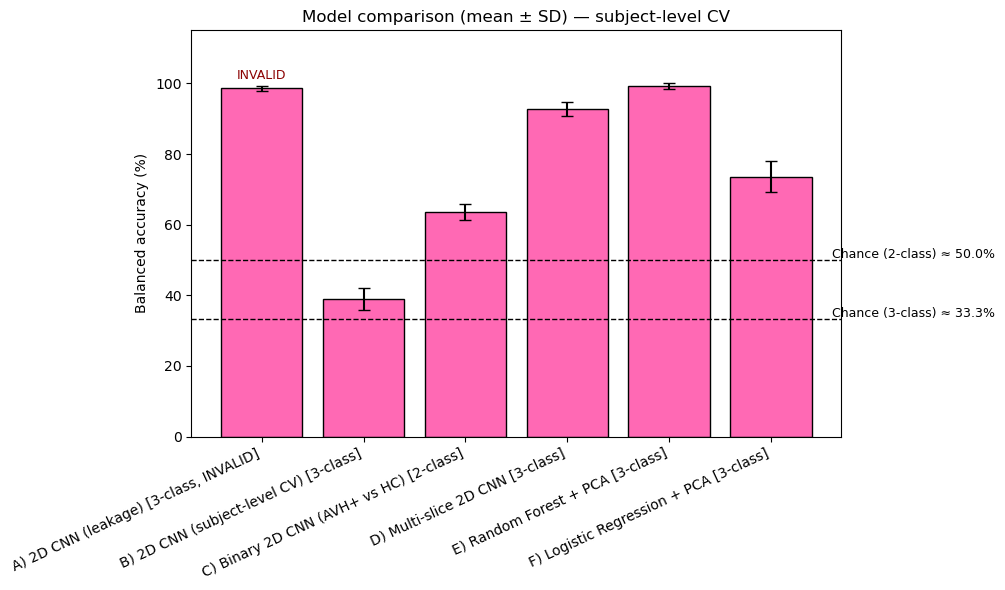

In [3]:
#Balanced accuracy
import numpy as np
import matplotlib.pyplot as plt

models = {
    "A) 2D CNN (leakage) [3-class, INVALID]": [99.3, 98.8, 97.9],
    "B) 2D CNN (subject-level CV) [3-class]": [34.9, 42.8, 39.0, 41.0, 37.0],
    "C) Binary 2D CNN (AVH+ vs HC) [2-class]": [65.0, 63.0, 64.0, 60.0, 66.0],
    "D) Multi-slice 2D CNN [3-class]": [95.0, 90.0, 92.0, 93.0, 94.0],
    "E) Random Forest + PCA [3-class]": [100.0, 99.0, 100.0, 98.0, 99.0],
    "F) Logistic Regression + PCA [3-class]": [69.0, 77.0, 73.0, 70.0, 79.0],}

#detect class count from label text to draw chance lines
def chance_from_label(lbl):
    return 50.0 if "[2-class]" in lbl else 33.3333
labels = list(models.keys())
means = np.array([np.mean(v) for v in models.values()])
sds   = np.array([np.std(v, ddof=1) if len(v) > 1 else 0.0 for v in models.values()])

x = np.arange(len(labels))
plt.figure(figsize=(10,6))
plt.bar(x, means, yerr=sds, capsize=4, color="hotpink", edgecolor="black")
plt.xticks(x, labels, rotation=25, ha="right")
plt.ylabel("Balanced accuracy (%)")
plt.title("Model comparison (mean ± SD) — subject-level CV")

#chance lines in black & invalid label
classes_set = {2 if "[2-class]" in l else 3 for l in labels}
for c in sorted(classes_set):
    y = 50.0 if c == 2 else 33.3333
    plt.axhline(y, linestyle="--", linewidth=1, color="black")
    plt.text(len(labels)-0.4, y+0.6, f"Chance ({c}-class) ≈ {y:.1f}%", fontsize=9, color="black")
for i,lbl in enumerate(labels):
    if "INVALID" in lbl:
        plt.text(i, means[i] + sds[i] + 2, "INVALID", ha="center", fontsize=9, color="darkred")

plt.ylim(0, max(means+sds)+15)
plt.tight_layout()
plt.show()